In [1]:
# imports the necessary libraries and modules
import numpy as np
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from torch.utils.data import random_split
from FreeFormDeformation import DeformationLayer
import matplotlib.pyplot as plt
from torch import nn, optim
from deepali.core import functional as U
from tqdm import tqdm
import os
from deepali.spatial import Grid, ImageTransformer, StationaryVelocityFreeFormDeformation

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Define the path where the dataset is stored
data_path = 'D:\\Dokumente\\03_RCI\\practical\\MNIST'

# Load the MNIST dataset without labels
mnist_dataset = MNIST(data_path, train=True, download=True, transform=None)
images = mnist_dataset.data.float()

# Print the shape of the images tensor
print(images.shape)
print(type(images))

torch.Size([60000, 28, 28])
<class 'torch.Tensor'>


In [6]:
# Make the same for cifar10
data_path = 'D:\\Dokumente\\03_RCI\\practical\\cifar10'
cifar10_dataset = datasets.CIFAR10(data_path, train=True, download=True, transform=None)
images_cifar10 = cifar10_dataset.data

# Convert to black and white
images = np.mean(images_cifar10, axis=3)
images = torch.from_numpy(images)
print(images.shape)
print(type(images))

Files already downloaded and verified
torch.Size([50000, 32, 32])
<class 'torch.Tensor'>


In [4]:
import imageio.v3 as iio

# load image to check if implementation is correct
images = iio.imread('D:\\Dokumente\\03_RCI\\practical\\Folder_structure\\Registration\\images\\square.png')
images = np.mean(images, axis=2)
images = torch.from_numpy(images)
images = torch.stack([images, images, images, images, images, images], dim=0)
print(images.shape)

torch.Size([6, 1600, 1600])


In [7]:
# Define a random fraction of the images
import random
random_fraction = 0.1
random_indices = random.sample(range(len(images)), int(random_fraction * len(images)))
images = images[random_indices]

transform = transforms.Resize((64, 64))
images = transform(images)

print(images.shape)
#print(type(images))
#print(images[0][:][:].max())


torch.Size([5000, 64, 64])


In [8]:
def get_mean_std(tensor):
    # Calculate the mean of the tensor
    mean = tensor.float().mean()
    
    # Calculate the standard deviation of the tensor
    std = tensor.float().std()
    
    return mean.item(), std.item()

mean, std = get_mean_std(images)
print(mean, std)

121.02122497558594 59.60927963256836


In [10]:
class CustomDataset(Dataset):
    def __init__(self, images, shape,transform=None):
        """
        Args:
            images (torch.Tensor): The tensor containing image data.
            shape: The shape of one image in the dataset.
            mean (float): The mean value for normalization.
            std (float): The standard deviation for normalization.
            transform (bool): Whether to apply the transformation.
        """
        self.images = images
        self.shape = shape
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def build_deformation_layer(self, device='cpu'):
        """
        Build and return a new deformation layer for each call to __getitem__.
        This method returns the created deformation layer.
        """
        deformation_layer = DeformationLayer(self.shape)
        deformation_layer.new_deformation(device=device)
        return deformation_layer

    def __getitem__(self, idx):
        # Fetch the original image
        original_image = self.images[idx].unsqueeze(0)  # Add batch dimension

        # Build a new deformation layer for the current image
        deformation_layer = self.build_deformation_layer()

        # Apply deformation to get the deformed image
        deformed_image = deformation_layer.deform(original_image)

        # Fetch the current deformation field
        deformation_field = deformation_layer.get_deformation_field().squeeze(0)
        
        # transform the images
        if self.transform:
            original_image = self.transform(original_image)
            deformed_image = self.transform(deformed_image)
            #print('mean and std of original image: ', original_image.mean(), original_image.std())
            #print('max and min of original image: ', original_image.max(), original_image.min())

        # Stack the original and deformed images along the channel dimension
        stacked_image = torch.cat([original_image, deformed_image], dim=0).squeeze(0)

        return stacked_image, deformation_field


In [11]:
# Assuming 'images' is a batch of images loaded as a PyTorch tensor
shape = images[0].shape[-2:]  # Image dimensions (height, width)

# Create dataset
dataset = CustomDataset(images, 
                        shape, 
                        transform=transforms.Compose([
                            transforms.Normalize(mean = [mean], std = [std]) ])
                        )
# trainset and testset
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Define the DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Max value of normalized images: 2.2476160733741346
Min value of normalized images: -2.0222029028356086
Max value of renormalized images: 1.0
Min value of renormalized images: 0.0
Batch Images Shape: torch.Size([32, 2, 64, 64])
Batch Deformation Fields Shape: torch.Size([32, 2, 64, 64])


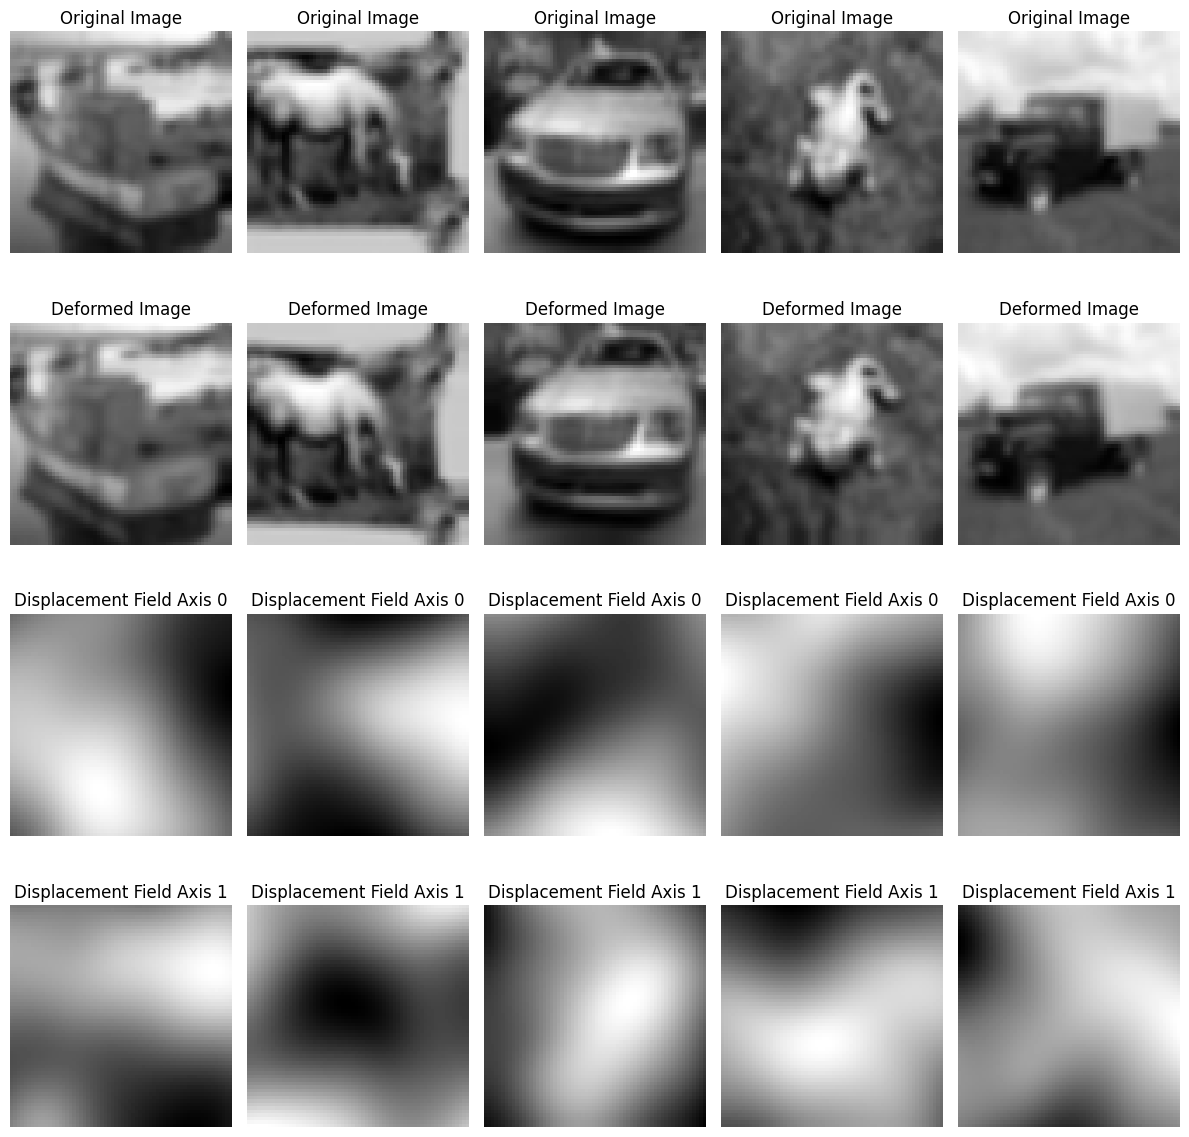

In [12]:
def renormalize(tensor):
        minFrom= tensor.min()
        maxFrom= tensor.max()
        minTo = 0
        maxTo=1
        return minTo + (maxTo - minTo) * ((tensor - minFrom) / (maxFrom - minFrom))

data_iter = iter(train_loader)
images, deformation_fields = next(data_iter)
print('Max value of normalized images:', float(images.max()))
print('Min value of normalized images:', float(images.min()))
images = renormalize(images)
print('Max value of renormalized images:', float(images.max()))
print('Min value of renormalized images:', float(images.min()))
# Printing shapes to ensure they are correct
print("Batch Images Shape:", images.shape)  # Should match [batch_size, channels, height, width]
print("Batch Deformation Fields Shape:", deformation_fields.shape)  # Should match expected format, e.g., [batch_size, 2, height, width]


# Define the number of samples to display
num_samples = 5

# Create a figure with subplots in a grid 2x4
fig, axes = plt.subplots(4, num_samples, figsize=(12, 12))

for i in range(num_samples):
    # Plotting the original and deformed images
    
    ax = axes[0, i]
    ax.imshow(images[i,0,:,:].numpy(), cmap='gray') # Original image
    ax.title.set_text('Original Image')
    ax.axis('off')

    ax = axes[1, i]
    ax.imshow(images[i,1].numpy(), cmap='gray') # Deformed image
    ax.title.set_text('Deformed Image')
    ax.axis('off')

    ax = axes[2, i] 
    ax.imshow(deformation_fields[i, 0].numpy(), cmap='gray')  # X-component of the field
    ax.title.set_text('Displacement Field Axis 0')
    ax.axis('off')

    ax = axes[3, i] 
    ax.imshow(deformation_fields[i, 1].numpy(), cmap='gray')  # Y-component of the field
    ax.title.set_text('Displacement Field Axis 1')
    ax.axis('off')

plt.tight_layout()
plt.show()




In [13]:
# set up u net model
from diffusion_unet import Unet
model = Unet(
    dim=8,  # Starting number of filters
    init_dim=None,
    out_dim=2,  # Output channels for x and y deformation fields
    dim_mults=(1, 2, 4, 8),  # Multipliers for the channel dimensions at each stage
    channels=2,  # Input has 2 channels (original and deformed images)
    resnet_block_groups=8,  # Number of groups for grouped convolution in Resnet blocks, tweak as needed
    learned_variance=False,  # Set based on whether you need to predict variance alongside deformation
    conditional_dimensions=0,  # Adjust if you use conditional inputs
    patch_size=1,  # Use 1 to avoid patching (since your data is already fairly low resolution)
    attention_layer=None  # Define layers where attention should be applied, if necessary
    
)

model.to(device)

if os.path.isfile('D:\\Dokumente\\03_RCI\\practical\\Folder_structure\\Registration\\weights\\best_model_64.pth'):
        model.load_state_dict(torch.load('D:\\Dokumente\\03_RCI\\practical\\Folder_structure\\Registration\\weights\\best_model_64.pth', map_location=device))


Attention lvl 0 8 8
Attention lvl 1 8 16
Attention lvl 2 16 32
Attention lvl 3 32 64


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004, weight_decay=1e-5)

In [ ]:
# Train the model
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    # Initialize tqdm progress bar for the training batches
    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Training Epoch {epoch+1}/{n_epochs}')
    for i, (images, deformation_field) in train_bar:
        # Move data to the device
        images = images.float().to(device)
        deformation_field = deformation_field.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        #loss = criterion(outputs, deformation_field)
        loss = criterion(outputs, deformation_field)
        train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Update the progress bar with the latest loss information
        train_bar.set_postfix(loss=loss.item())
    
    # Compute the average training loss
    avg_train_loss = train_loss / len(train_loader)
    
    # Validate
    model.eval()
    val_loss = 0
    # Initialize tqdm progress bar for the validation batches
    val_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc='Validation')
    with torch.no_grad():
        for i, (images, deformation_field) in val_bar:
            # Move validation data to the device
            images = images.float().to(device)
            deformation_field = deformation_field.to(device)
            
            outputs = model(images)
            batch_loss = criterion(outputs, deformation_field).item()
            val_loss += batch_loss
            
            # Update the progress bar for validation
            val_bar.set_postfix(val_loss=batch_loss)
        
        # Compute the average validation loss
        avg_val_loss = val_loss / len(val_loader)
        print(f'Validation Loss: {avg_val_loss}')

Training Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, val_loss=0.172]


Validation Loss: 0.17218656837940216


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, val_loss=0.0688]


Validation Loss: 0.06879498064517975


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it, val_loss=0.0523]


Validation Loss: 0.052337609231472015


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, val_loss=0.043]


Validation Loss: 0.04296956956386566


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, val_loss=0.0434]


Validation Loss: 0.04344533756375313


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it, val_loss=0.0297]


Validation Loss: 0.02968655526638031


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, val_loss=0.0343]


Validation Loss: 0.034278254956007004


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, val_loss=0.0257]


Validation Loss: 0.025741491466760635


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, val_loss=0.0227]


Validation Loss: 0.022664006799459457


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, val_loss=0.0179]


Validation Loss: 0.01790553331375122


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.0144]


Validation Loss: 0.014368383213877678


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.0141]


Validation Loss: 0.014084790833294392


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.0155]


Validation Loss: 0.015499552711844444


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, val_loss=0.0175]


Validation Loss: 0.01749994233250618


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, val_loss=0.0162]


Validation Loss: 0.016179094091057777


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, val_loss=0.0134]


Validation Loss: 0.013352771289646626


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, val_loss=0.0154]


Validation Loss: 0.01542188785970211


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, val_loss=0.0132]


Validation Loss: 0.013167938217520714


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.0138]


Validation Loss: 0.013827309012413025


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, val_loss=0.0123]

Validation Loss: 0.012298962101340294


In [14]:
import torch
import torch.nn.functional as F

def deform_image(deformed_image: torch.Tensor, displacement_field: torch.Tensor, device) -> torch.Tensor:
    """
    Deform a grayscale image using the given displacement field.

    Args:
        deformed_image (torch.Tensor): Grayscale image of shape (H, W).
        displacement_field (torch.Tensor): Displacement field of shape (2, H, W).

    Returns:
        torch.Tensor: Deformed image of shape (H, W).
    """
    # Ensure the input image and displacement field are on the same device
    deformed_image = deformed_image.to(device)
    displacement_field = displacement_field.to(device)
    
    # invert the displacement field
    displacement_field = -displacement_field

    # Create grid coordinates
    H, W = deformed_image.shape
    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
    grid = torch.stack([grid_x, grid_y], dim=0).float().to(device)  # Shape: (2, H, W)

    # Add displacement field to grid
    new_grid = grid
    new_grid = new_grid.permute(1, 2, 0).unsqueeze(0)  # Shape: (1, H, W, 2)

    # Normalize grid values to be in the range [-1, 1]
    new_grid[..., 0] = 2.0 * new_grid[..., 0] / (W - 1) - 1.0
    new_grid[..., 1] = 2.0 * new_grid[..., 1] / (H - 1) - 1.0
    new_grid = new_grid + displacement_field.permute(1, 2, 0).unsqueeze(0)

    # Interpolate original image using the new grid
    deformed_image = deformed_image.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
    deformed_image = F.grid_sample(deformed_image, new_grid, mode='bilinear', padding_mode='border')

    return deformed_image.squeeze(0).squeeze(0)

d:\Dokumente\03_RCI\practical\Folder_structure\.conda\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
d:\Dokumente\03_RCI\practical\Folder_structure\.conda\Lib\site-packages\torch\nn\functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


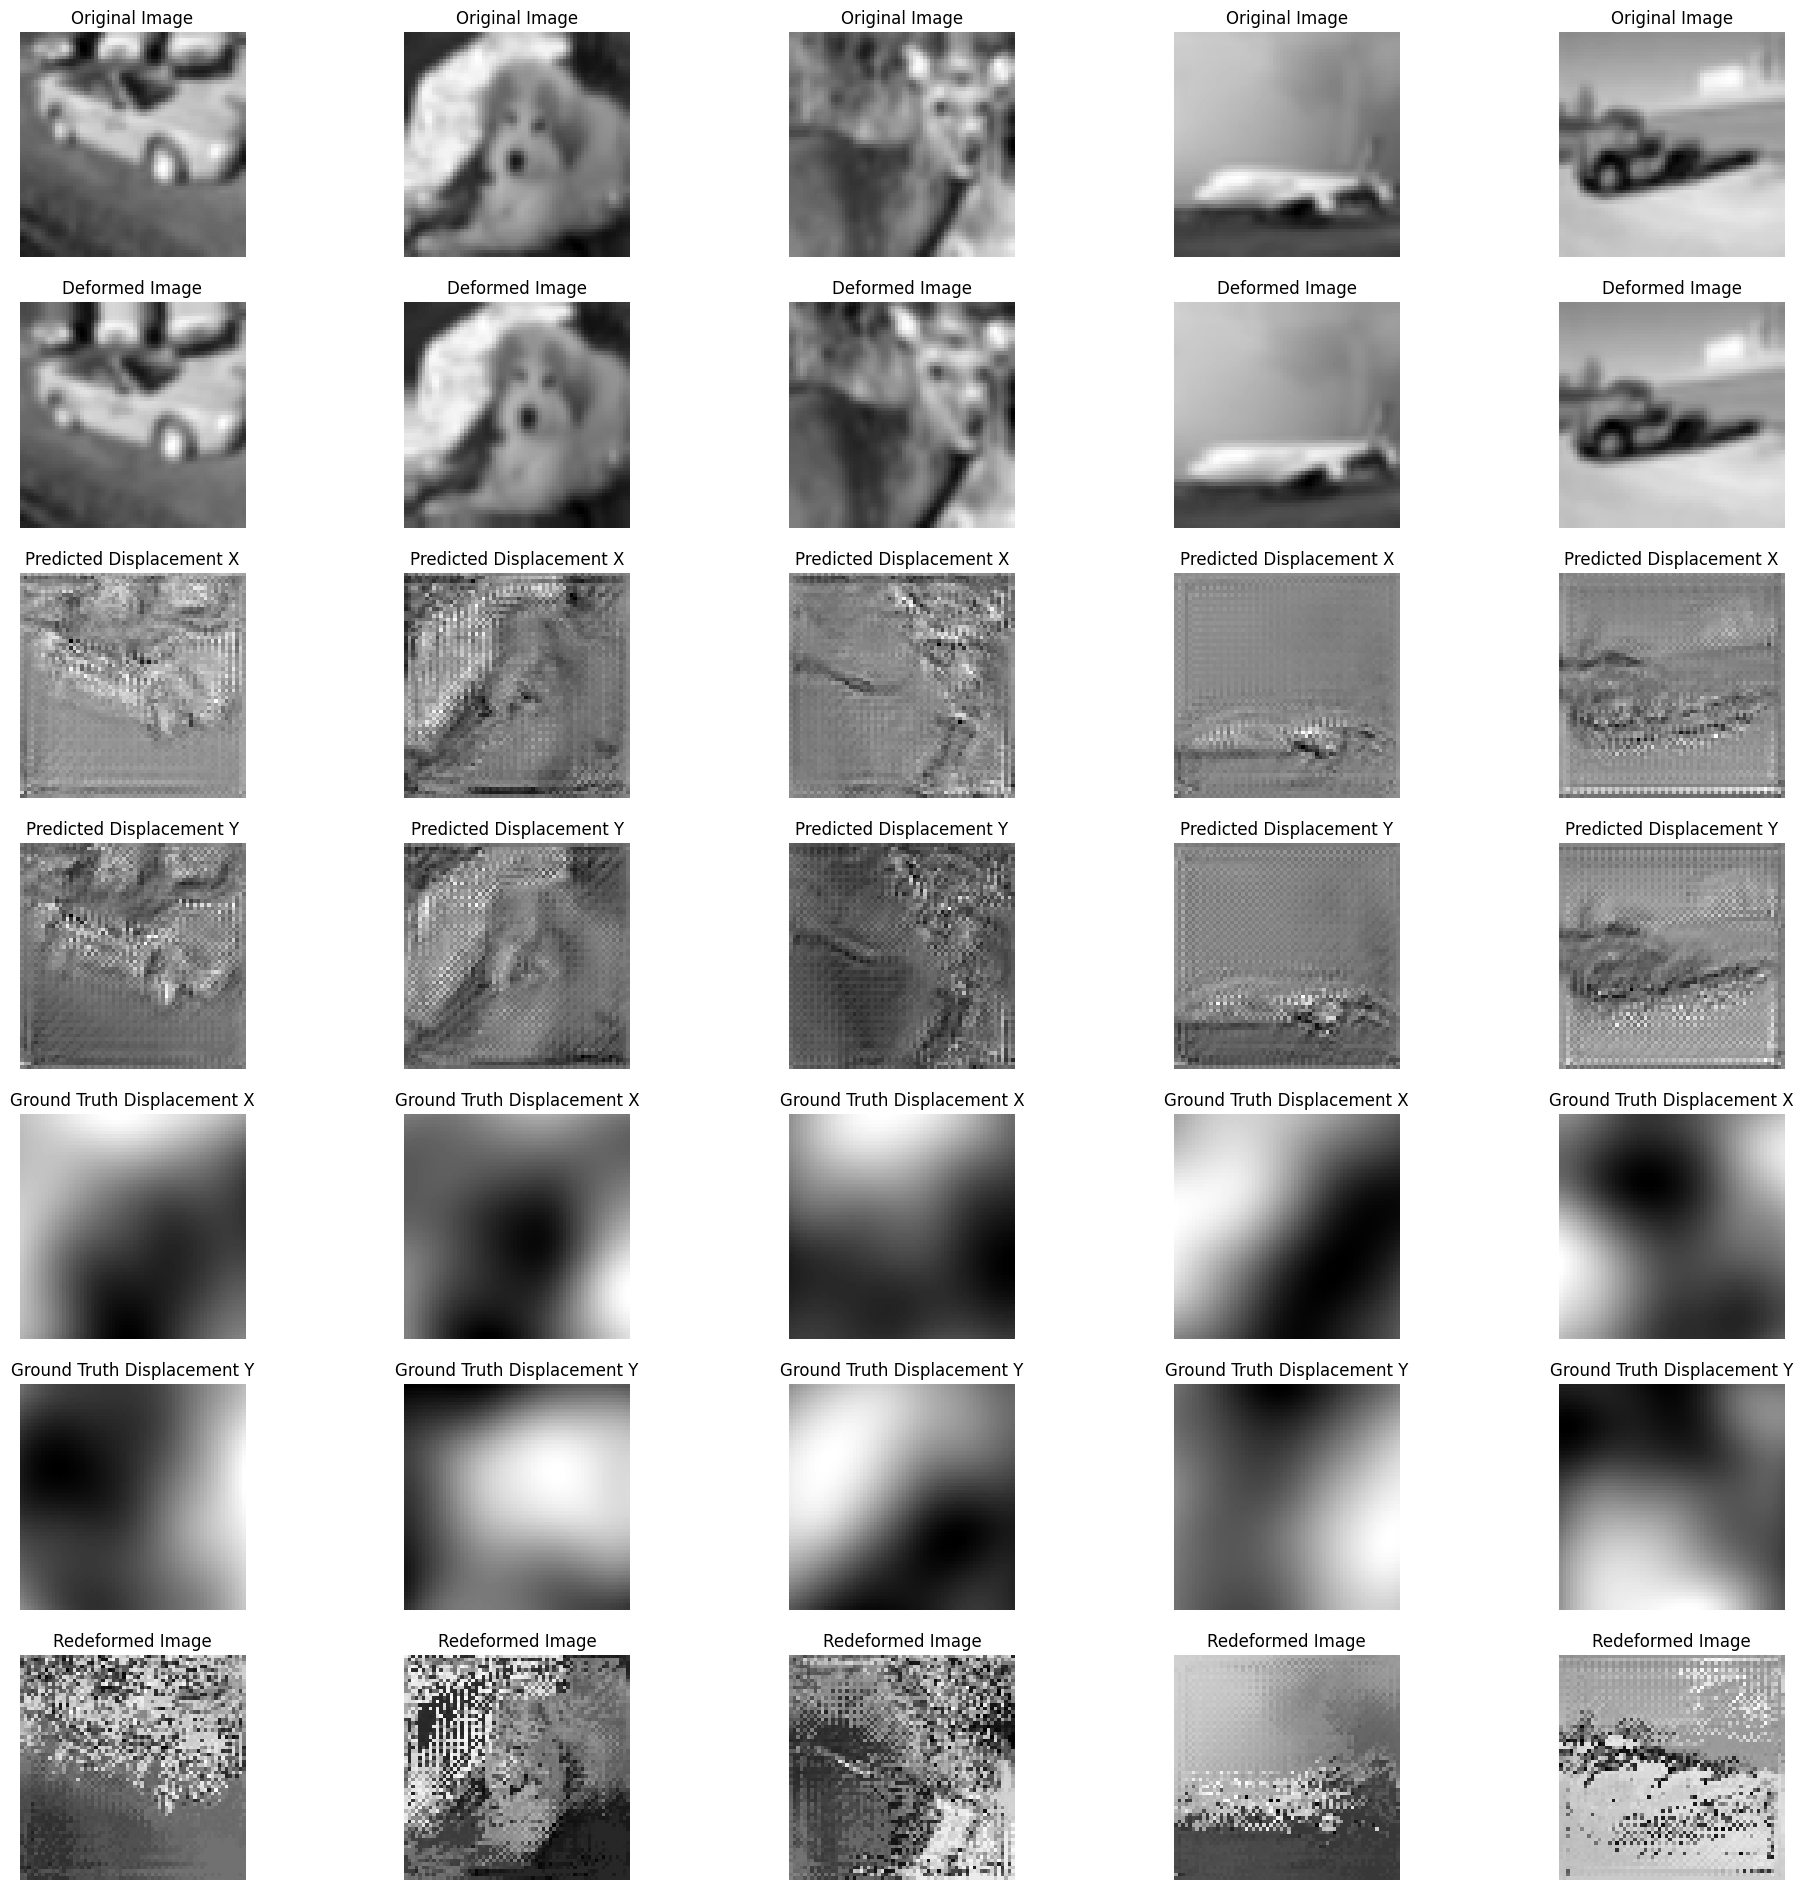

In [15]:
# Get some predichted DF and images from the trained model

model.eval()
with torch.no_grad():
    images, deformation_fields = next(iter(test_loader))
    # Move data to the device
    images = images.float().to(device)
    deformation_fields = deformation_fields.to(device)
    
    outputs = model(images)
    
    # Plot the original and deformed images
    fig, axes = plt.subplots(7, num_samples, figsize=(24, 24))
    for i in range(num_samples):

        ax = axes[0, i] # [0, i]
        ax.imshow(images[i, 0].numpy(), cmap='gray')
        ax.title.set_text('Original Image')
        ax.axis('off')

        ax = axes[1, i] # [1, i]
        ax.imshow(images[i, 1].numpy(), cmap='gray')
        ax.title.set_text('Deformed Image')
        ax.axis('off')

        ax = axes[2, i] # [2, i]
        ax.imshow(outputs[i, 0].numpy(), cmap='gray')
        ax.title.set_text('Predicted Displacement X')
        ax.axis('off')
        
        ax = axes[3, i]      
        ax.imshow(outputs[i, 1].numpy(), cmap='gray')
        ax.title.set_text('Predicted Displacement Y')
        ax.axis('off')
        
        ax = axes[4, i]
        ax.imshow(deformation_fields[i, 0].numpy(), cmap='gray')
        ax.title.set_text('Ground Truth Displacement X')
        ax.axis('off')
        
        ax = axes[5, i]
        ax.imshow(deformation_fields[i, 1].numpy(), cmap='gray')
        ax.title.set_text('Ground Truth Displacement Y')
        ax.axis('off')        
        
        inverse_transformed_image = deform_image(images[i, 1], outputs[i], device)
        #print(inverse_transformed_image.shape)
        ax = axes[6, i]
        ax.imshow(inverse_transformed_image, cmap='gray')
        ax.title.set_text('Redeformed Image')
        ax.axis('off')  
    

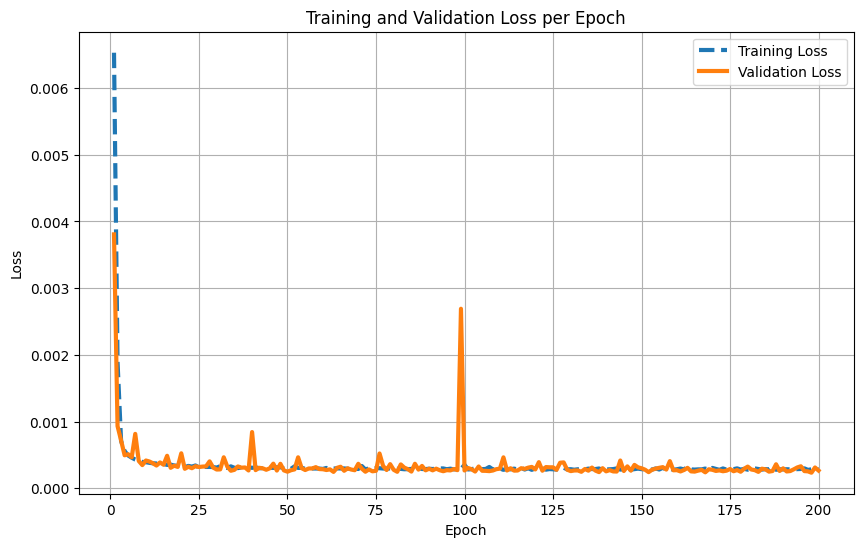

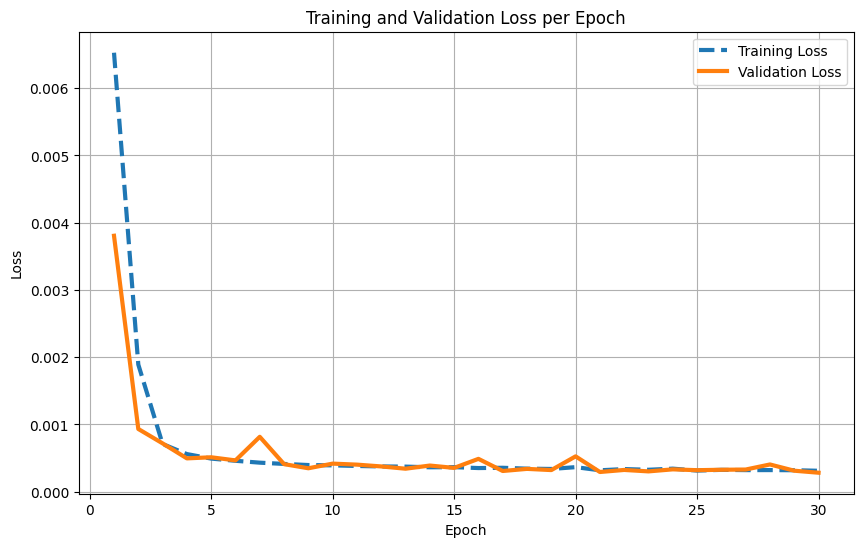

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
log_file_path = 'D:\\Dokumente\\03_RCI\\practical\\Folder_structure\\Registration\\logs\\losses_128.csv'  # Replace with your actual file path
df = pd.read_csv(log_file_path)

plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train_loss'], label='Training Loss', linestyle='--',linewidth=3)
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss',linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# plot only the first 20 epochs
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'][:30], df['train_loss'][:30], label='Training Loss', linestyle='--',linewidth=3)
plt.plot(df['epoch'][:30], df['val_loss'][:30], label='Validation Loss',linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()




In [17]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Ensure the images are in the correct range [0, 1] or [0, 255]
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

# Compute similarity measures of image and redeformed image from validation data (SSIM, PSNR, MSE, L1)
model.eval()
with torch.no_grad():
    avg_ssim = 0
    avg_psnr = 0
    avg_mse = 0
    avg_l1 = 0

    total_images = 0

    for i, (images, deformation_field) in enumerate(val_loader):
        # Move validation data to the device
        images = images.float().to(device)
        deformation_field = deformation_field.to(device)
        
        outputs = model(images)
        
        batch_size = images.size(0)
        total_images += batch_size
        
        for j in range(batch_size):
            redeformed_image = deform_image(images[j, 1], outputs[j], device)
            
            # Normalize images before SSIM calculation
            img_0_norm = normalize_image(images[j, 0].cpu().numpy())
            redeformed_img_norm = normalize_image(redeformed_image.cpu().numpy())
            #print('Deformed image generated')
            
            # SSIM
            ssim_value = ssim(img_0_norm, redeformed_img_norm, data_range=1.0)
            avg_ssim += ssim_value
            
            # MSE
            mse_value = F.mse_loss(images[j, 0], redeformed_image)
            avg_mse += mse_value.item()
            
            # L1
            l1_value = F.l1_loss(images[j, 0], redeformed_image)
            avg_l1 += l1_value.item()
            
            # PSNR
            psnr_value = 10 * torch.log10(1 / mse_value)
            avg_psnr += psnr_value.item()
    
    # Normalize by the total number of images processed
    avg_ssim /= total_images
    avg_psnr /= total_images
    avg_mse /= total_images
    avg_l1 /= total_images

print(f"SSIM:  {avg_ssim}")
print(f"PSNR:  {avg_psnr}")
print(f"MSE:   {avg_mse}")
print(f"L1:    {avg_l1}")



d:\Dokumente\03_RCI\practical\Folder_structure\.conda\Lib\site-packages\torch\nn\functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated
Deformed image generated


In [ ]:
# compare with original vs moving image
model.eval()
with torch.no_grad():
    avg_ssim = 0
    avg_psnr = 0
    avg_mse = 0
    avg_l1 = 0

    total_images = 0

    for i, (images, deformation_field) in enumerate(val_loader):
        # Move validation data to the device
        images = images.float().to(device)
        deformation_field = deformation_field.to(device)
        
        outputs = model(images)
        
        batch_size = images.size(0)
        total_images += batch_size
        
        for j in range(batch_size):
            
            # Normalize images before SSIM calculation
            img_0_norm = normalize_image(images[j, 0].cpu().numpy())
            img_1_norm = normalize_image(images[j, 1].cpu().numpy())
            
            # SSIM
            ssim_value = ssim(img_0_norm, img_1_norm, data_range=1.0)
            avg_ssim += ssim_value
            
            # MSE
            mse_value = F.mse_loss(images[j, 0], images[j, 1])
            avg_mse += mse_value.item()
            
            # L1
            l1_value = F.l1_loss(images[j, 0], images[j, 1])
            avg_l1 += l1_value.item()
            
            # PSNR
            psnr_value = 10 * torch.log10(1 / mse_value)
            avg_psnr += psnr_value.item()
    
    # Normalize by the total number of images processed
    avg_ssim /= total_images
    avg_psnr /= total_images
    avg_mse /= total_images
    avg_l1 /= total_images

print(f"SSIM:  {avg_ssim}")
print(f"PSNR:  {avg_psnr}")
print(f"MSE:   {avg_mse}")
print(f"L1:    {avg_l1}")


SSIM:  0.4658820097628866
PSNR:  6.7101988454558885
MSE:   0.2765451532802545
L1:    0.31755459159985183
